In [1]:
import os
import time
import subprocess
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import re
import pickle

import random
seed = 42 # Set the seed for reproducibility
random.seed(seed) # For Python's built-in random module (if you use it anywhere)


In [12]:
%run Q4p_create_prompts.py

Number of RecordIDs with at least one death (1) entry: 554
RecordID
132539.0    Avg Age: 54.0, Last Age: 54.0 | Avg Weight: 80...
132540.0    Avg Age: 76.0, Last Age: 76.0 | Avg Weight: 81...
132541.0    Avg Age: 44.0, Last Age: 44.0 | Avg Weight: 56...
132543.0    Avg Age: 68.0, Last Age: 68.0 | Avg Weight: 84...
132545.0    Avg Age: 88.0, Last Age: 88.0 | Avg Weight: 80...
dtype: object
Avg Age: 54.0, Last Age: 54.0 | Avg Weight: 80.6, Last Weight: 80.6 | Avg Gender: 0.0, Last Gender: 0.0 | Avg Height: 170.2, Last Height: 170.2 | Avg BUN: 12.55, Last BUN: 8.0 | Avg Creatinine: 0.79, Last Creatinine: 0.7 | Avg GCS: 14.91, Last GCS: 15.0 | Avg Glucose: 161.15, Last Glucose: 115.0 | Avg HCO3: 26.26, Last HCO3: 28.0 | Avg HCT: 32.34, Last HCT: 30.3 | Avg HR: 72.4, Last HR: 86.0 | Avg K: 4.21, Last K: 4.0 | Avg Mg: 1.72, Last Mg: 1.9 | Avg NIDiasABP: 49.24, Last NIDiasABP: 55.0 | Avg NIMAP: 70.47, Last NIMAP: 79.33 | Avg NISysABP: 112.91, Last NISysABP: 128.0 | Avg Na: 137.06, Last Na: 13

In [2]:
with open('Q4p1_prompts_list.pkl', 'rb') as file:
    prompts_list_from_file = pickle.load(file)

In [3]:
len(prompts_list_from_file)
#print(prompts_list_from_file[:1]) 

3998

In [4]:
import os
import pickle
from ollama import chat

# Iterate over the prompts_list_from_file instead of files
responses = []  # List to store the responses for all prompts

# Define the role text
role_txt = """You are a helpful assistant to a doctor and want to predict whether the case patients die or survive. Return for the last case whether you think the patient will die or survive based on their values, considering the examples given, and that the death rate for 4000 cases is only 14%. State your response only and exactly with the string 'outcome:survival Index:' or 'outcome:death Index:' plus the original index number, and "Score:", + a score of 1 to 100 which is the probability that the patient is to die (100= certain death)."""
# Save the responses in a pickle file
output_pickle_path = 'Q4p1/Q4p1_responses_all.pkl'

run_script = False

if run_script:
    for prompt in prompts_list_from_file[:]:
        # Append the role_txt to the prompt
        prompt = prompt + "\n" + role_txt
    
        # Call Ollama model with streaming responses for each prompt
        stream = chat(
            model='gemma2:2b',
            messages=[{'role': 'user', 'content': prompt}],
            stream=True,
        )
    
        # Collect the response and process it
        response = ''
        for chunk in stream:
            response += chunk['message']['content']
            # Uncomment the next line if you want to print as the response streams
            # print(chunk['message']['content'], end='', flush=True)
    
        # Add the response to the list
        responses.append(response)
    
        print("\n")  # Add a newline after processing each prompt
        
        with open(output_pickle_path, 'wb') as file:
            pickle.dump(responses, file)
    
    print(f"Responses saved as '{output_pickle_path}'")


In [5]:
# Save the responses in a pickle file
output_pickle_path = 'Q4p1/Q4p1_responses_all.pkl'
with open(output_pickle_path, 'rb') as file:
    pkl_data_all = pickle.load(file)
len(pkl_data_all)

3998

In [6]:
# Initialize the list to hold all data
all_data = []

# Function to clean the file name (if needed)
def clean_file_name(file_name):
    return file_name.replace("outcome:death", "").replace("outcome:survival", "")

# Function to clean the file name (extract the index number from the entry)
def extract_index(entry):
    match = re.search(r"Index:\s*(\d+)", entry)
    if match:
        return match.group(1)  # Return the index number as string
    return "unknown"  # If no index is found, return "unknown"

# Function to extract the score from the entry
def extract_score(entry):
    match = re.search(r"Score:\s*(\d+(\.\d+)?)", entry)  # Matches integers or decimals
    if match:
        return match.group(1)  # Return the score as string
    return "unknown"  # If no score is found, return "unknown"

# Parse the pkl data and extract information
for entry in pkl_data_all:
    if "outcome:death" in entry or "outcome:survival" in entry:
        # Extract the outcome
        outcome = entry.split(' ')[0]  # Assuming the outcome is the first word in the entry (outcome:death or outcome:survival)
        
        # Extract the index number to use as the file name
        file_name = extract_index(entry)
        
        # Extract the score
        score = extract_score(entry)
        
        # Add to the all_data list
        all_data.append({"RecordID": file_name, "outcome": outcome, "score": score})

# If you want to print or further inspect the data
print(len(all_data))

3998


In [7]:
df = pd.DataFrame(all_data)
print(df.head())
df['pred'] = df['outcome'].apply(lambda x: 1 if "outcome:death" in x else 0)

print(df["pred"])
print(df['RecordID'])

df.head()
# Check the type of the 'outcome2' column
print(df['RecordID'].dtype)
df['RecordID'] = pd.to_numeric(df['RecordID'], errors='coerce').astype('Int64')  # Using 'Int64' to allow NaN support
print(df['RecordID'].dtype)

  RecordID           outcome score
0   152871  outcome:survival    90
1   152873  outcome:survival    90
2   152875  outcome:survival    90
3   152878  outcome:survival    90
4   152882  outcome:survival    75
0       0
1       0
2       0
3       0
4       0
       ..
3993    1
3994    0
3995    0
3996    1
3997    1
Name: pred, Length: 3998, dtype: int64
0       152871
1       152873
2       152875
3       152878
4       152882
         ...  
3993    163029
3994    163033
3995    163034
3996    163035
3997    163037
Name: RecordID, Length: 3998, dtype: object
object
Int64


In [8]:
testing_df_path = 'loaded_data/c_patient_data_NOT_scaled.parquet'
# read the parquet file
testing_df = pd.read_parquet(testing_df_path)

testing_df["In-hospital_death"].head()
testing_df["RecordID"].head()
# Ensure the 'RecordID' column is of integer type
testing_df["RecordID"] = testing_df["RecordID"].astype(int)
testing_df.head()


# remove blank spaces in the RecordID column
df["RecordID"]
df.head()
df.head()
df_true_vals = testing_df[["In-hospital_death", "RecordID"]].drop_duplicates()

In [9]:
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, roc_auc_score, average_precision_score

# Merge the two dataframes on the 'RecordID' column
merged_df = df_true_vals.merge(df, left_on="RecordID", right_on="RecordID", how="inner")
print(merged_df.head(200))

# Perform sensitivity analysis
y_true = merged_df["In-hospital_death"]
y_pred = merged_df["pred"]
y_pred

# Calculate sensitivity (recall for the positive class)
sensitivity = recall_score(y_true, y_pred)

# Print the sensitivity and other metrics
print("Sensitivity (Recall):", sensitivity)
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))

# Optional: Display confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

     In-hospital_death  RecordID           outcome score  pred
0                    0    152871  outcome:survival    90     0
1                    1    152873  outcome:survival    90     0
2                    0    152875  outcome:survival    90     0
3                    0    152878  outcome:survival    90     0
4                    0    152882  outcome:survival    75     0
..                 ...       ...               ...   ...   ...
195                  0    153348  outcome:survival    95     0
196                  0    153349  outcome:survival    90     0
197                  0    153355  outcome:survival    95     0
198                  0    153357     outcome:death    60     1
199                  0    153359  outcome:survival    80     0

[200 rows x 5 columns]
Sensitivity (Recall): 0.3379073756432247
Accuracy: 0.6790185277916875
Precision: 0.18023787740164685
Confusion Matrix:
 [[2515  896]
 [ 386  197]]


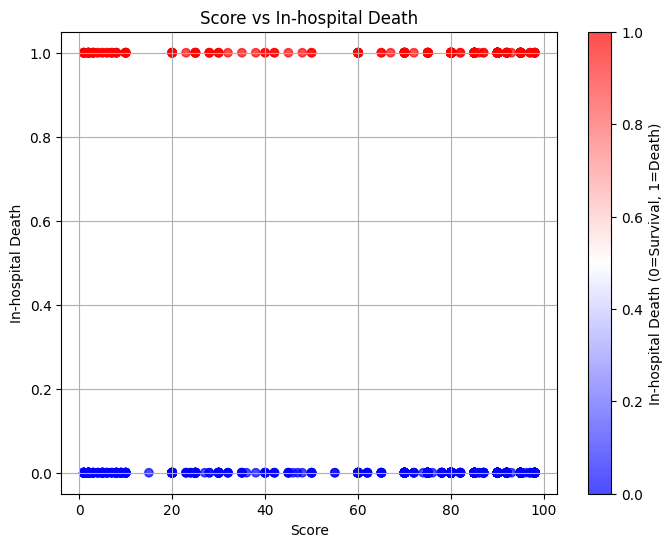

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

merged_df['score'] = pd.to_numeric(merged_df['score'], errors='coerce') 

# Plotting Score vs In-hospital_death
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['score'], merged_df['In-hospital_death'], c=merged_df['In-hospital_death'], cmap='bwr', alpha=0.7)
plt.title('Score vs In-hospital Death')
plt.xlabel('Score')
plt.ylabel('In-hospital Death')
plt.grid(True)
plt.colorbar(label='In-hospital Death (0=Survival, 1=Death)')
plt.show()


12
0.4504561722165148
0.13221472133693493


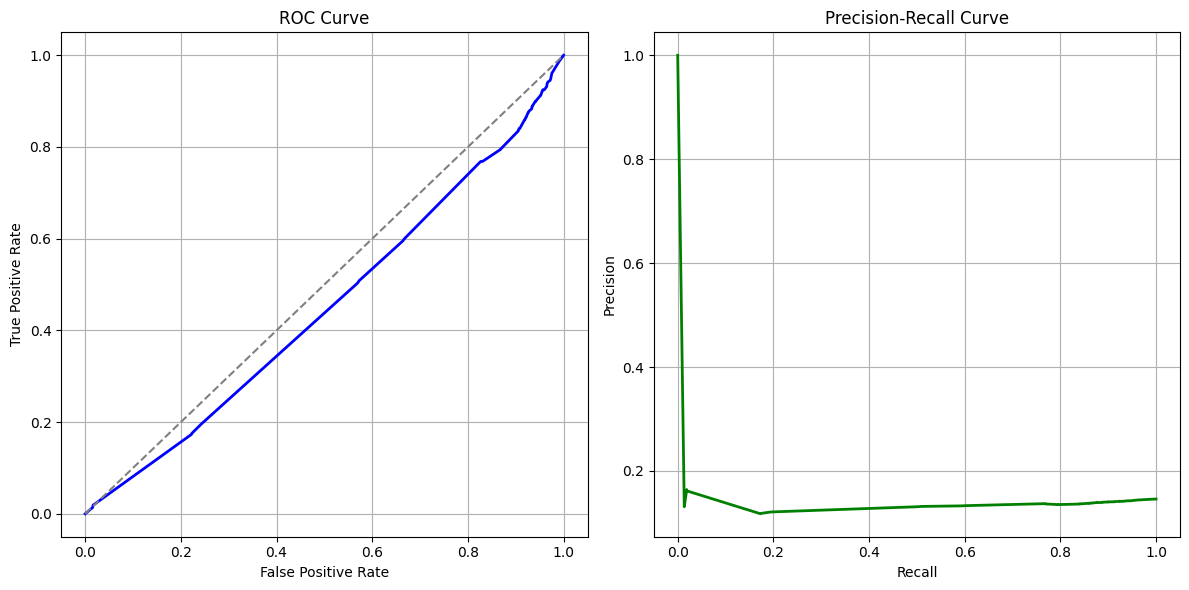

In [11]:
from sklearn.metrics import roc_curve, precision_recall_curve

score = merged_df['score']/100
nan_pred_vals = score.isna().sum()
print(nan_pred_vals)
score = score.fillna(score.mean())

# Assuming y_pred_proba contains the predicted probabilities for the positive class (class 1)
fpr, tpr, _ = roc_curve(y_true, score)
precision, recall, _ = precision_recall_curve(y_true, score)

# Calculate AUROC (Area Under the Receiver Operating Characteristic Curve)
auroc = roc_auc_score(y_true, score)

# Calculate AUPRC (Area Under the Precision-Recall Curve)
auprc = average_precision_score(y_true, score)

print(auroc)
print(auprc)

# ROC Curve
plt.figure(figsize=(12, 6))

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

plt.tight_layout()
plt.show()